# Comparison of velocities between EM and VI model

## Library imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
import torch
from pygam import GAM
from scipy.stats import pearsonr, spearmanr, ttest_ind
from sklearn.metrics import accuracy_score
from velovi import preprocess_data, VELOVI

import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from matplotlib.colors import to_hex

import scanpy as sc
import scvelo as scv
import scvi
from scvelo.plotting.simulation import compute_dynamics

from _calculation import get_gams

sys.path.append("../..")
from paths import DATA_DIR, FIG_DIR

Global seed set to 0


## General settings

In [3]:
scvi.settings.dl_pin_memory_gpu_training = False

In [4]:
sns.reset_defaults()
sns.reset_orig()
scv.settings.set_figure_params('scvelo', dpi_save=400, dpi=80, transparent=True, fontsize=20, color_map='viridis')

In [5]:
SAVE_FIGURES = True
if SAVE_FIGURES:
    os.makedirs(FIG_DIR / 'comparison', exist_ok=True)

## Function definitions

In [6]:
def fit_scvelo(adata):
    scv.tl.recover_dynamics(
        adata, fit_scaling=False, var_names=adata.var_names, n_jobs=8
    )
    adata.var["fit_scaling"] = 1.0
    scv.tl.velocity(adata, mode="dynamical", min_likelihood=-np.inf, min_r2=None)

In [7]:
def fit_velovi(bdata):
    VELOVI.setup_anndata(bdata, spliced_layer="Ms", unspliced_layer="Mu")

    vae = VELOVI(bdata)
    vae.train()

    df = vae.history["elbo_train"].iloc[20:].reset_index().rename(columns={'elbo_train': 'elbo'})
    df['set'] = 'train'

    _df = vae.history["elbo_validation"].iloc[20:].reset_index().rename(columns={'elbo_validation': 'elbo'})
    _df['set'] = 'validation'

    df = pd.concat([df, _df], axis=0).reset_index(drop=True)

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))
        sns.lineplot(data=df, x='epoch', y='elbo', hue='set', palette=['#0173B2', '#DE8F05'], ax=ax)

    latent_time = vae.get_latent_time(n_samples=25)
    velocities = vae.get_velocity(n_samples=25, velo_statistic="mean")

    t = latent_time
    scaling = 20 / t.max(0)

    bdata.layers["velocities_velovi"] = velocities / scaling
    bdata.layers["latent_time_velovi"] = latent_time

    bdata.var["fit_alpha"] = vae.get_rates()["alpha"] / scaling
    bdata.var["fit_beta"] = vae.get_rates()["beta"] / scaling
    bdata.var["fit_gamma"] = vae.get_rates()["gamma"] / scaling
    bdata.var["fit_t_"] = (
        torch.nn.functional.softplus(vae.module.switch_time_unconstr)
        .detach()
        .cpu()
        .numpy()
    ) * scaling
    bdata.layers["fit_t"] = latent_time.values * scaling[np.newaxis, :]
    bdata.var['fit_scaling'] = 1.0

    return vae

In [8]:
def compute_confidence(adata, vkey="velocity"):
    velo = adata.layers[vkey]
    scv.tl.velocity_graph(adata, vkey=vkey, n_jobs=8)
    scv.tl.velocity_confidence(adata, vkey=vkey)

    g_df = pd.DataFrame()
    g_df["Velocity confidence"] = adata.obs[f"{vkey}_confidence"].to_numpy().ravel()

    return g_df

In [9]:
def add_significance(ax, left: int, right: int, significance: str, level: int = 0, **kwargs):
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)
    
    bottom, top = ax.get_ylim()
    y_axis_range = top - bottom

    bracket_level = (y_axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (y_axis_range * bracket_height)

    ax.plot(
        [left, left, right, right],
        [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs
    )

    
    ax.text(
        (left + right) * 0.5,
        bracket_level + (y_axis_range * text_height),
        significance,
        ha='center',
        va='bottom',
        c='k'
    )

In [10]:
def get_classification_scores(velo_sign_true, velo_sign_pred, score_fun, **kwargs):
    n_vars = velo_sign_true.shape[1]
    em_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["EM"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]

    vi_score = [
        score_fun(velo_sign_true[:, var_id], velo_sign_pred["VI"][:, var_id], **kwargs)
        for var_id in range(n_vars)
    ]
    
    return em_score, vi_score

In [11]:
def get_significance(pvalue):
    if pvalue < 0.001:
        return "***"
    elif pvalue < 0.01:
        return "**"
    elif pvalue < 0.1:
        return "*"
    else:
        return "n.s."

In [12]:
def plot_classification_score(em_score, vi_score, baseline_performance, score_name, **kwargs):
    n_vars = len(em_score)
    df = pd.DataFrame(
        {
            score_name: vi_score + em_score + baseline_performance,
            "Model": ["VI"] * n_vars + ["EM"] * n_vars + ["Random"] * n_vars
        }
    )

    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(6, 4))

        sns.boxplot(data=df, x="Model", y=score_name, palette="colorblind", ax=ax)

## Data loading

In [13]:
adata = sc.read(DATA_DIR / "scEU" / "gex_raw.h5ad")
adata = adata[adata.obs["labeling_time"] != "dmso", :]
adata.obs['labeling_time'] = adata.obs['labeling_time'].astype(float)
adata = adata[adata.obs['experiment'] == "Pulse", :].copy()

adata.layers["unspliced"] = adata.layers["unlabeled_unspliced"] + adata.layers["labeled_unspliced"]
adata.layers["spliced"] = adata.layers["unlabeled_spliced"] + adata.layers["labeled_spliced"]

adata.obs["pseudo_clusters"] = pd.cut(adata.obs["cell_cycle_position"], bins=30, labels=False).astype(str).astype("category")

adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["cell_cycle_position"], q=30, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)

adata.obs["cell_cycle_rad"] = adata.obs["cell_cycle_position"] / adata.obs["cell_cycle_position"].max() * 2 * np.pi

adata

AnnData object with n_obs × n_vars = 2793 × 11848
    obs: 'experiment', 'labeling_time', 'plate_id', 'well_id', 'cell_cycle_position', 'RFP_log10_corrected', 'GFP_log10_corrected', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad'
    layers: 'labeled_spliced', 'labeled_unspliced', 'new', 'total', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

## Data preprocessing

In [14]:
scv.pp.filter_and_normalize(adata, min_counts=10, layers_normalize=['X', 'new', 'total', 'unspliced', 'spliced'], n_top_genes=2000)

Filtered out 905 genes that are detected 10 counts (spliced).
Normalized count data: X, new, total, unspliced, spliced.
Extracted 2000 highly variable genes.
Logarithmized X.


In [15]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)

scv.pp.moments(adata, n_pcs=None, n_neighbors=None)
adata.layers["Ms_log1p"] = np.log1p(adata.layers["Ms"])

computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [16]:
sc.tl.umap(adata)

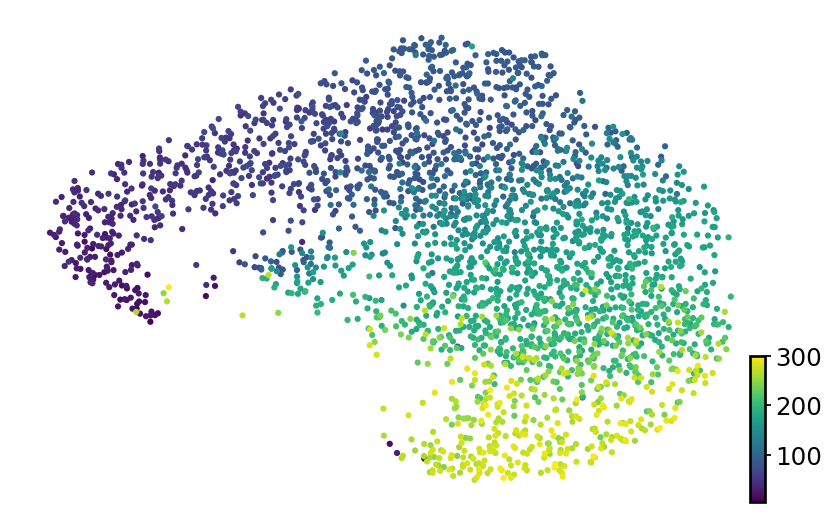

In [17]:
with mplscience.style_context():
    fig, ax = plt.subplots(figsize=(6, 4))
    scv.pl.scatter(adata, basis='umap', color='cell_cycle_position', cmap='viridis', title='', ax=ax)

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'sceu_cell_cycle_umap.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [18]:
adata = preprocess_data(adata)

bdata = adata.copy()

cdata = adata.copy()

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [19]:
((adata.layers["Mu"] == 0) & (adata.layers["Ms"] == 0)).mean()

0.008771929824561403

## Model fitting

### EM model

In [20]:
fit_scvelo(adata)

recovering dynamics (using 8/14 cores)


  0%|          | 0/140 [00:00<?, ?gene/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0


    finished (0:00:08) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


### VI model

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 314/500:  63%|██████▎   | 314/500 [01:59<01:10,  2.63it/s, loss=-121, v_num=1]
Monitored metric elbo_validation did not improve in the last 45 records. Best score: -115.002. Signaling Trainer to stop.


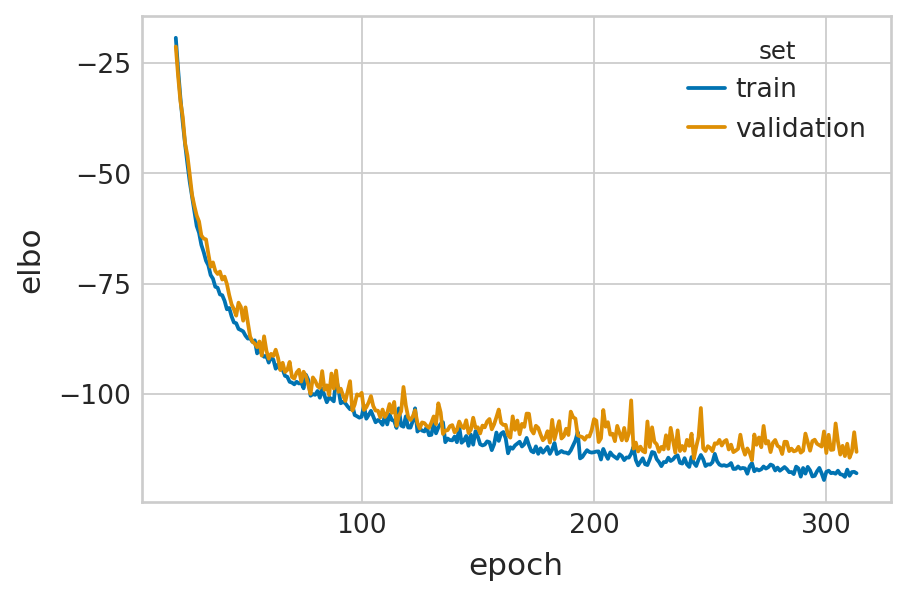

In [21]:
velovi_vae = fit_velovi(bdata)

### Empirical velocity

In [22]:
aggr_counts = []
for pos in tqdm(np.sort(adata.obs["cell_cycle_position"].unique())):
    mask = (adata.obs["cell_cycle_position"] == pos).values

    aggr_counts.append(np.median(adata.layers["Ms"][mask, :], axis=0))

aggr_counts = np.vstack(aggr_counts)

100%|██████████| 290/290 [00:00<00:00, 4516.30it/s]


In [23]:
reorder_mask = np.arange(1, adata.obs["cell_cycle_rad"].nunique()).tolist() + [0]
cell_cycle_pos = adata.obs["cell_cycle_rad"].values

cc_pos_diff = np.sort(np.unique(cell_cycle_pos))
cc_pos_diff = (cc_pos_diff[reorder_mask] - cc_pos_diff) % (2 * np.pi)

empirical_velo = (aggr_counts[reorder_mask, :] - aggr_counts) / cc_pos_diff.reshape(-1, 1)

empirical_velo_sign = np.sign(empirical_velo)

### Velocity processing

In [24]:
aggr_velo = {"EM": [], "VI": []}

for pos in tqdm(np.sort(adata.obs["cell_cycle_position"].unique())):
    mask = (adata.obs["cell_cycle_position"] == pos).values

    aggr_velo["EM"].append(np.median(adata.layers["velocity"][mask, :], axis=0))
    aggr_velo["VI"].append(np.median(bdata.layers["velocities_velovi"][mask, :], axis=0))

aggr_velo["EM"] = np.vstack(aggr_velo["EM"])
aggr_velo["VI"] = np.vstack(aggr_velo["VI"])

100%|██████████| 290/290 [00:00<00:00, 3295.36it/s]


In [25]:
aggr_velo_sign = {}
aggr_velo_sign["EM"] = np.sign(aggr_velo["EM"])
aggr_velo_sign["VI"] = np.sign(aggr_velo["VI"])

## Velocity confidence

In [26]:
dfs = []

g_df = compute_confidence(adata)
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "EM model"
dfs.append(g_df)

g_df = compute_confidence(bdata, vkey="velocities_velovi")
g_df["Dataset"] = "Cell cycle"
g_df["Method"] = "veloVI"
dfs.append(g_df)

conf_df = pd.concat(dfs, axis=0)

computing velocity graph (using 8/14 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)
computing velocity graph (using 8/14 cores)


  0%|          | 0/2793 [00:00<?, ?cells/s]

    finished (0:00:02) --> added 
    'velocities_velovi_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocities_velovi_length' (adata.obs)
--> added 'velocities_velovi_confidence' (adata.obs)
--> added 'velocities_velovi_confidence_transition' (adata.obs)


/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


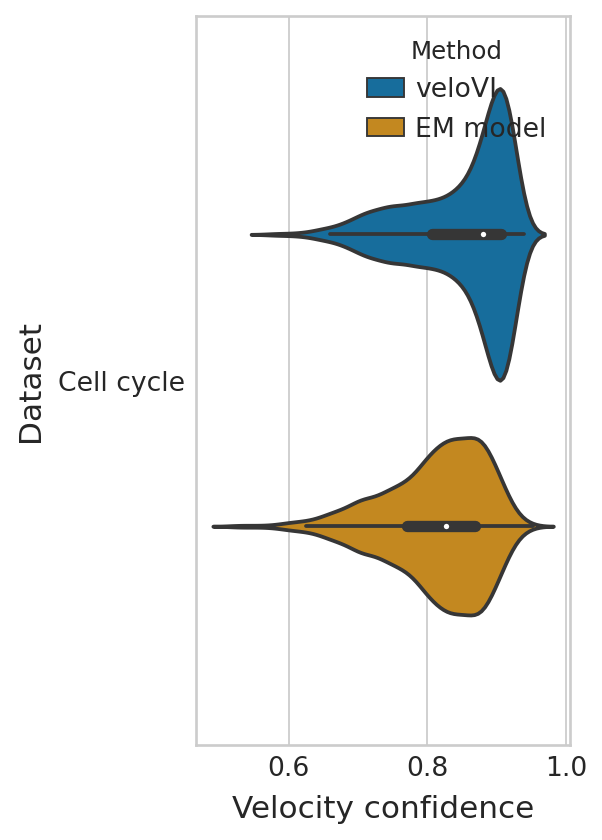

In [27]:
with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(3, 6))
    sns.violinplot(
        data=conf_df,
        ax=ax,
        orient="h",
        y="Dataset",
        x="Velocity confidence",
        hue="Method",
        hue_order=["veloVI", "EM model"],
        palette=sns.color_palette(['#0173B2', '#DE8F05']),
    );

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'sceu_velocity_confidence.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

## GAM fitting

In [28]:
gams = {}

gams["EM"] = get_gams(adata=adata, layer="velocity", time="cell_cycle_rad", n_jobs=8)
gams["VI"] = get_gams(adata=bdata, layer="velocities_velovi", time="cell_cycle_rad", n_jobs=8)

100%|██████████| 140/140 [00:00<00:00, 262.05it/s]


In [29]:
cell_cycle_score = adata.obs["cell_cycle_rad"].values
cell_cycle_score = np.vstack([cell_cycle_score - 2 * np.pi, cell_cycle_score, cell_cycle_score + 2 * np.pi]).T

adata.var["gam_r2_scores"] = [
    gam._estimate_r2(X=cell_cycle_score, y=adata.layers["velocity"][:, var_id])["McFadden"]
    for var_id, gam in enumerate(gams["EM"].values())
]

bdata.var["gam_r2_scores"] = [
    gam._estimate_r2(X=cell_cycle_score, y=bdata.layers["velocities_velovi"][:, var_id])["McFadden"]
    for var_id, gam in enumerate(gams["VI"].values())
]

/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/pygam/utils.py:649: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bases = (x >= aug_knots[:-1]).astype(np.int) * \
/vol/storage/miniconda3/envs/velovi-py39/lib/python3.9/site-packages/pygam/utils.py:650: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If yo

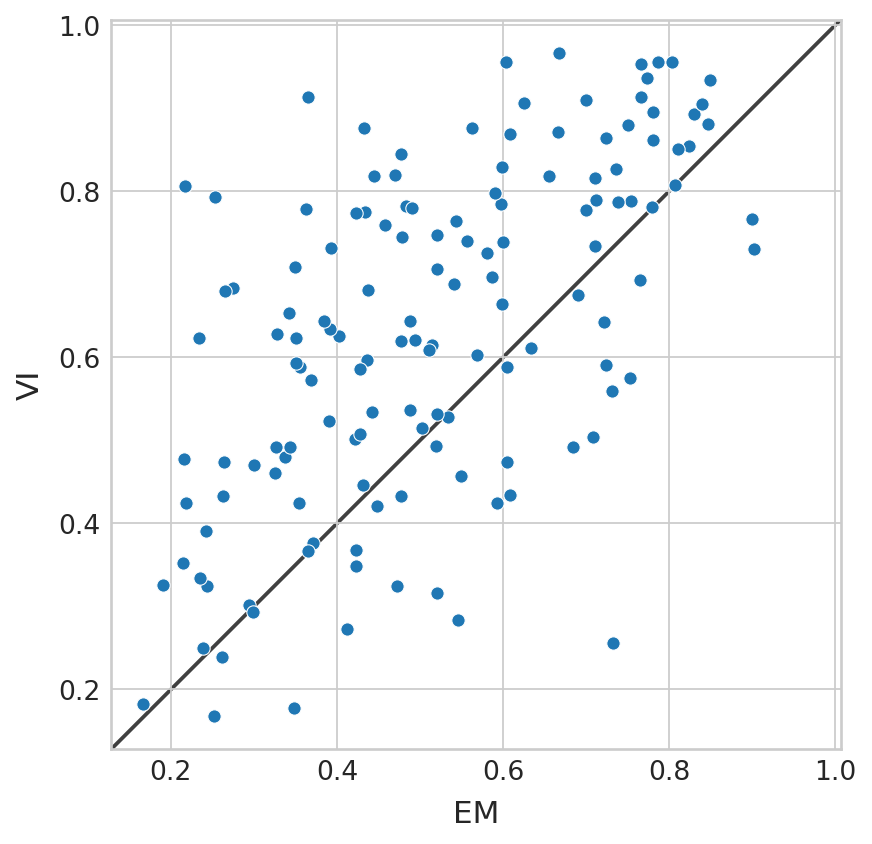

In [30]:
df = pd.DataFrame(
    {
        "EM": adata.var["gam_r2_scores"].values,
        "VI": bdata.var["gam_r2_scores"].values,
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.scatterplot(data=df, x="EM", y="VI", ax=ax)
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'sceu_gam_r2.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )

In [31]:
(bdata.var["gam_r2_scores"].values > adata.var["gam_r2_scores"].values).mean()

0.7785714285714286

## Estimated velocity vs. empirical velocity

In [32]:
np.random.seed(0)
random_velo_sign = np.random.choice([-1, 0, 1], size=(len(adata.obs["cell_cycle_position"].unique()), adata.n_vars))
baseline_performance = [
    accuracy_score(empirical_velo_sign[:, var_id], random_velo_sign[:, var_id])
    for var_id in range(adata.n_vars)
]

In [33]:
em_score, vi_score = get_classification_scores(
    velo_sign_true=empirical_velo_sign,
    velo_sign_pred=aggr_velo_sign,
    score_fun=accuracy_score,
)

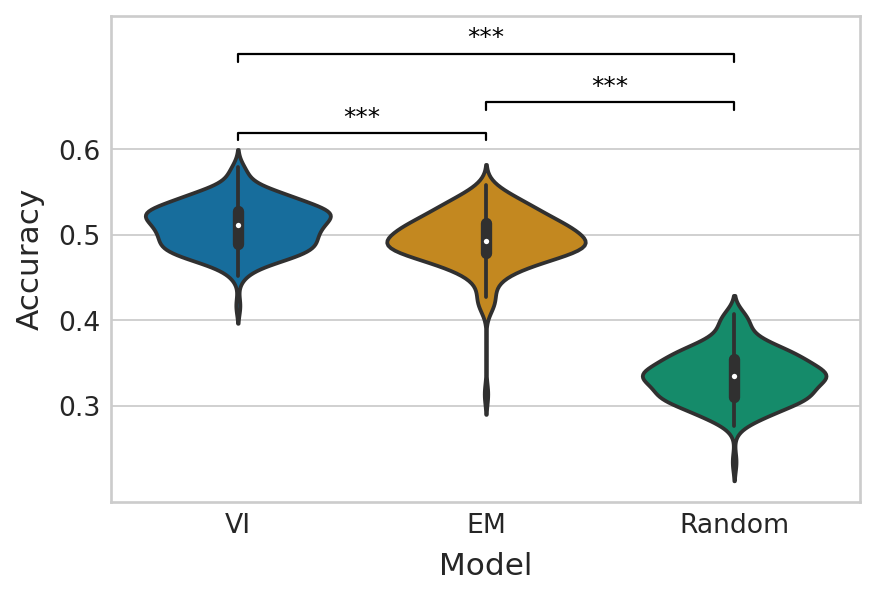

In [34]:
df = pd.DataFrame(
    {
        "Accuracy": vi_score + em_score + baseline_performance,
        "Model": ["VI"] * adata.n_vars + ["EM"] * adata.n_vars + ["Random"] * adata.n_vars
    }
)

with mplscience.style_context():
    sns.set_style(style="whitegrid")
    fig, ax = plt.subplots(figsize=(6, 4))

    sns.violinplot(data=df, x="Model", y="Accuracy", palette="colorblind", ax=ax)

    ttest_res = ttest_ind(vi_score, em_score, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=1, significance=significance, lw=1, c="k", level=0,
    )
    
    ttest_res = ttest_ind(em_score, baseline_performance, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=1, right=2, significance=significance, lw=1, c="k", level=1, bracket_level=0.975
    )

    ttest_res = ttest_ind(em_score, baseline_performance, equal_var=False, alternative="greater")
    significance = get_significance(ttest_res.pvalue)
    add_significance(
        ax=ax, left=0, right=2, significance=significance, lw=1, c="k", level=2, bracket_level=0.95
    )
    
    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max + 0.02])
    
    ax.set_yticks([0.3, 0.4, 0.5, 0.6]) 
    ax.set_yticklabels([0.3, 0.4, 0.5, 0.6]);

if SAVE_FIGURES:
    fig.savefig(
        FIG_DIR / 'comparison' / 'sceu_velocity_sign_accuracy.svg',
        format="svg",
        transparent=True,
        bbox_inches='tight'
    )